In [1]:
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
from os import listdir, path
import random

In [13]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    if (len(image.shape) < 3):
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points 
    # (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    #NO SIGNIFICANT IMPROVEMENT
    #new_image = cv2.Canny(new_image,30,100)


    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

# Converts a rbg image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def load_data(dir_list, image_size): #input [first_class, second_class, etc] and (image_width, image_height)

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        
        # Output is 0 for no, 1 for yes
        y_val = 0
        if directory.endswith('yes'):
            y_val = 1
        
        for filename in listdir(directory):
            # load the image
            #image = cv2.imread(directory + '\\' + filename)
            image = cv2.imread(path.join(directory, filename), cv2.IMREAD_UNCHANGED)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_NEAREST)
            
            # Convert image to grayscale if necessary
            if len(image.shape) != 2:
                image = rgb2gray(image)
            
            # normalize values
            image = image / 255.
            
            X.append(image)
            y.append(y_val)           
            
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data for good measure
    X, y = shuffle(X, y, random_state=0)

    return X.reshape(X.shape[0], 128**2), y

# Split dataset
def split_data(X, y, test_s=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_s, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
    return X_train, y_train, X_val, y_val, X_test, y_test


#Load data set
dir_list = ['TumorDatasetFinal/no', 'TumorDatasetFinal/yes']
image_size = (128, 128)
X, y = load_data(dir_list, image_size)

# Split dataset (80% train, 10% validation, 10% test)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [5]:
def build_model(X, y, epochs):
    loss = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in epochs:
        model = sklearn.linear_model.LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', warm_start=True, random_state=0, max_iter=i).fit(X_train, y_train)
        y_pred = model.predict(X)
        loss.append(sklearn.metrics.log_loss(y, y_pred))
        accuracy.append(sklearn.metrics.accuracy_score(y, y_pred))
        precision.append(sklearn.metrics.precision_score(y, y_pred))
        recall.append(sklearn.metrics.recall_score(y, y_pred))
        f1.append(sklearn.metrics.f1_score(y, y_pred))
    
    return model, loss, accuracy, precision, recall, f1

def plot_metrics(train_metric, val_metric, test_metric, metric_name, epochs):
    plt.plot(train_metric, label='Training %s'%metric_name)
    plt.plot(val_metric, label='Validation %s'%metric_name)
    plt.plot(test_metric, label='Test %s'%metric_name)
    plt.title(metric_name)
    plt.xlabel('Epoch #')
    plt.ylabel(metric_name)
    plt.xticks(np.arange(0,6), epochs)
    plt.legend()
    plt.show()
    plt.figure()


In [10]:
%%time

#Run training, validation and test sets
EPOCH = [100,200, 500, 700, 1000, 1500]
#model = sklearn.linear_model.LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', warm_start=True, random_state=0).fit(X_train, y_train)
train_model, train_loss, train_accuracy, train_precision, train_recall, train_f1 = build_model(X_train, y_train, EPOCH)
val_model, val_loss, val_accuracy, val_precision, val_recall, val_f1 = build_model(X_val, y_val, EPOCH)
test_model, test_loss, test_accuracy, test_precision, test_recall, test_f1 = build_model(X_test, y_test, EPOCH)

/Users/inesgonzalezpepe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/inesgonzalezpepe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/inesgonzalezpepe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/inesgonzalezpepe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/inesgonzalezpepe/opt/anaconda3/li

CPU times: user 43min 10s, sys: 14.1 s, total: 43min 24s
Wall time: 44min 13s


/Users/inesgonzalezpepe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


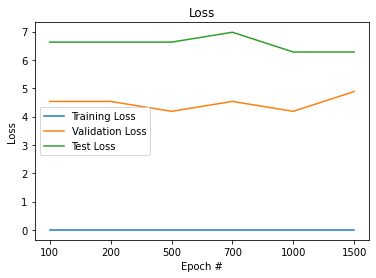

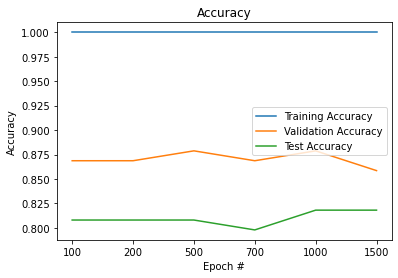

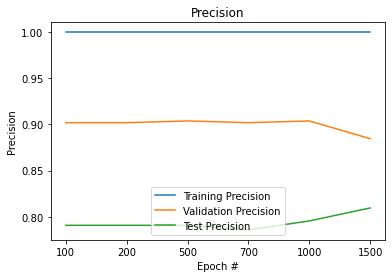

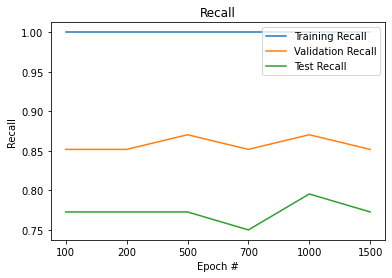

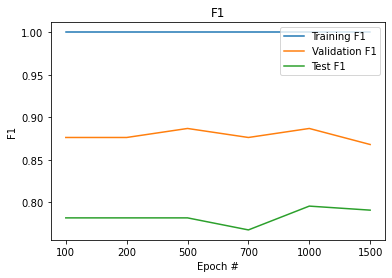

<Figure size 432x288 with 0 Axes>

In [11]:
plot_metrics(train_loss, val_loss, test_loss, 'Loss', EPOCH)
plot_metrics(train_accuracy, val_accuracy, test_accuracy, 'Accuracy', EPOCH)
plot_metrics(train_precision, val_precision, test_precision, 'Precision', EPOCH)
plot_metrics(train_recall, val_recall, test_recall, 'Recall', EPOCH)
plot_metrics(train_f1, val_f1, test_f1, 'F1', EPOCH)

In [12]:
#output metrics to a file
output = open('Output/Edge_LogisticRegressionStats.txt', 'w') #Add in edge to file name when testing image enhancement
output.write('Training loss: ' + str(train_loss) + '\n')
output.write('Validation loss: ' + str(val_loss) + '\n')
output.write('Testing loss: ' + str(test_loss) + '\n')
output.write('Training accuracy: ' + str(train_accuracy) + '\n')
output.write('Validation accuracy: ' + str(val_accuracy) + '\n')
output.write('Testing accuracy: ' + str(test_accuracy) + '\n')
output.write('Training precision: ' + str(train_precision) + '\n')
output.write('Validation precision: ' + str(val_precision) + '\n')
output.write('Testing precision: ' + str(test_precision) + '\n')
output.write('Training recall: ' + str(train_recall) + '\n')
output.write('Validation recall: ' + str(val_recall) + '\n')
output.write('Testing recall: ' + str(test_recall) + '\n')
output.write('Training f1: ' + str(train_f1) + '\n')
output.write('Validation f1: ' + str(val_f1) + '\n')
output.write('Testing f1: ' + str(test_f1) + '\n')
output.close()